# Produce lifetime XY map

<i>
This notebook takes a clean kDST, measures the lifetime at
different points of the XY plane and stores this map in
a hdf5 file.
</i>

### Notebook configuration

In [1]:
run_number          = 4628
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   60
Enbins  =  100
Qnbins  =  100

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename  = os.path.expandvars( input_dst_filename)
correction_filename = os.path.expandvars(correction_filename)

save = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1370239 
Total number of events: 1367621


In [5]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

### Event distribution

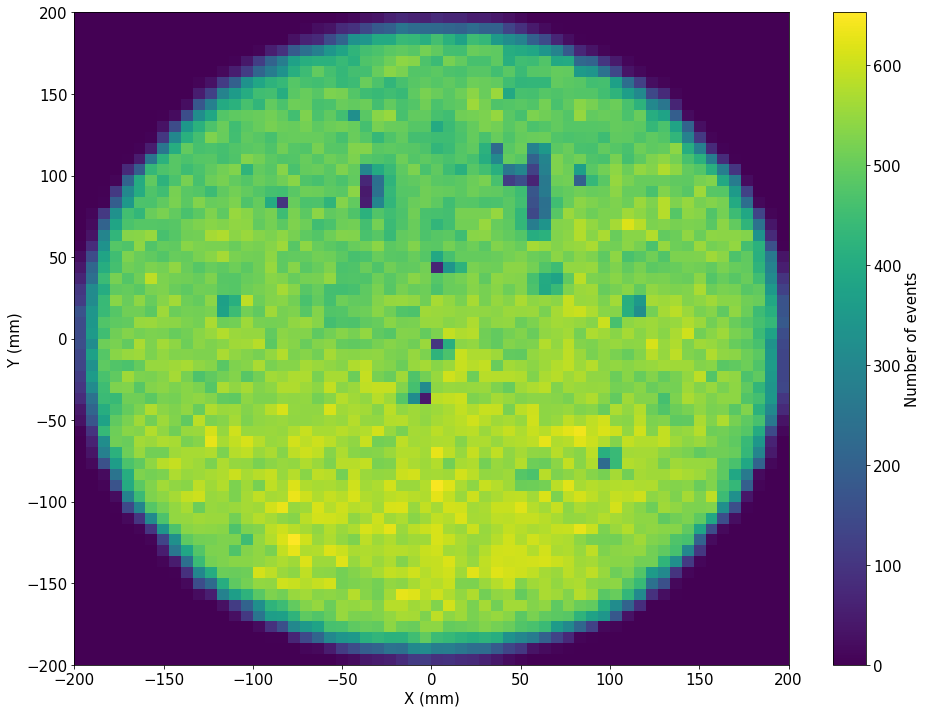

In [6]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")
save(f"EventDistribution_{XYpitch:.1f}mm_XY")

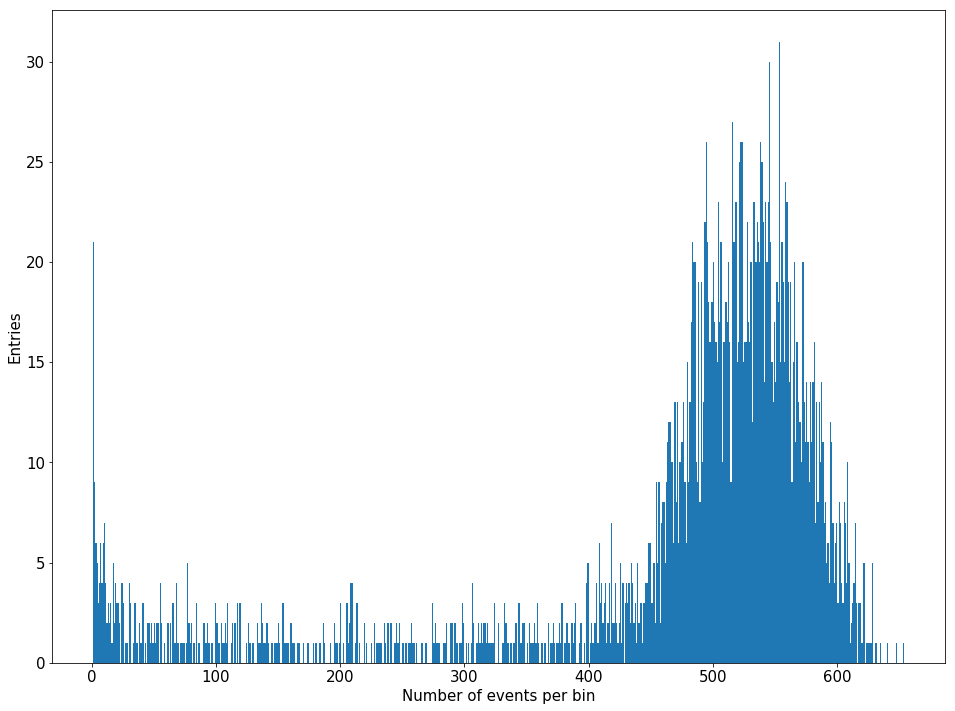

In [7]:
nevt_max = int(np.max(nevt))
plt.hist(nevt.flatten(), np.arange(1, nevt_max + 2))
labels("Number of events per bin", "Entries", "# events per bin")
save(f"EventDistribution_{XYpitch:.1f}mm")

### Compute lifetime maps

In [8]:
Escale_abs, ELT_abs,\
Echi2, Eok = fit_slices_2d_expo(X, Y, Z, E, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)
Eok        = ELT_abs.value < -100
Escale     = to_relative(Escale_abs, percentual=True)
ELT        = to_relative(   ELT_abs, percentual=True)

In [9]:
Qscale_abs, QLT_abs,\
Qchi2, Qok = fit_slices_2d_expo(X, Y, Z, Q, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)
Qok        = QLT_abs.value < -100
Qscale     = to_relative(Qscale_abs, percentual=True)
QLT        = to_relative(   QLT_abs, percentual=True)

In [10]:
ELT_mean  = np.nanmean(ELT   .value      [Eok])
ELT_std   = np.nanstd (ELT   .value      [Eok])
ELTu_mean = np.nanmean(ELT   .uncertainty[Eok])
ELTu_std  = np.nanstd (ELT   .uncertainty[Eok])

E_mean    = np.nanmean(Escale.value      [Eok])
E_std     = np.nanstd (Escale.value      [Eok])
Eu_mean   = np.nanmean(Escale.uncertainty[Eok])
Eu_std    = np.nanstd (Escale.uncertainty[Eok])

QLT_mean  = np.nanmean(QLT   .value      [Qok])
QLT_std   = np.nanstd (QLT   .value      [Qok])
QLTu_mean = np.nanmean(QLT   .uncertainty[Qok])
QLTu_std  = np.nanstd (QLT   .uncertainty[Qok])

Q_mean    = np.nanmean(Qscale.value      [Qok])
Q_std     = np.nanstd (Qscale.value      [Qok])
Qu_mean   = np.nanmean(Qscale.uncertainty[Qok])
Qu_std    = np.nanstd (Qscale.uncertainty[Qok])

In [11]:
E_min    =        E_mean - 3.0 *    E_std
E_max    =        E_mean + 2.0 *    E_std

ELT_min  =     -ELT_mean - 2.0 *  ELT_std
ELT_max  =     -ELT_mean + 2.0 *  ELT_std

Eu_min   = max(  Eu_mean - 1.5 *   Eu_std, 1e-3)
Eu_max   =       Eu_mean + 2.0 *   Eu_std

ELTu_min = max(ELTu_mean - 1.5 * ELTu_std, 1e-3)
ELTu_max =     ELTu_mean + 2.0 * ELTu_std

Q_min    =        Q_mean - 3.0 *    Q_std
Q_max    =        Q_mean + 2.0 *    Q_std

QLT_min  =     -QLT_mean - 4.0 *  QLT_std
QLT_max  =     -QLT_mean + 3.0 *  QLT_std

Qu_min   = max(  Qu_mean - 1.5 *   Qu_std, 1e-3)
Qu_max   =       Qu_mean + 2.0 *   Qu_std

QLTu_min = max(QLTu_mean - 1.5 * QLTu_std, 1e-3)
QLTu_max =     QLTu_mean + 2.0 * QLTu_std

### Fit examples

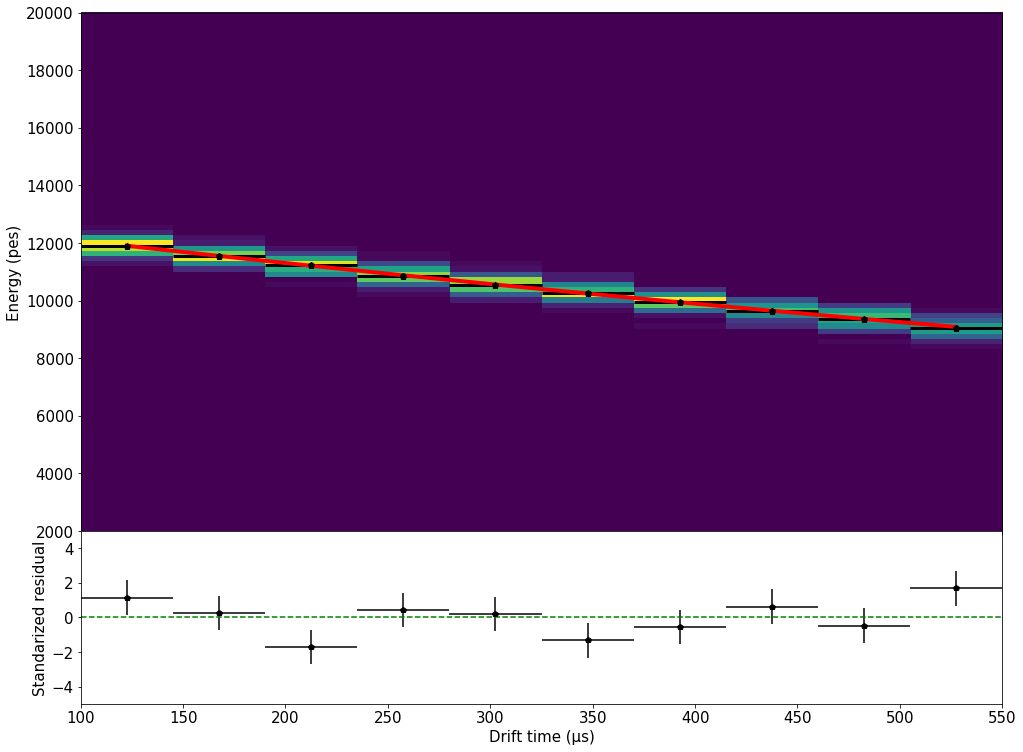

In [12]:
xlim =  15,  25
ylim = -25, -15
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
z, e = Z[sel], E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.hist2d(z, e, (Zbins, Ebins))

x, y, yu = fitf.profileX(z, e, Znbins, Zrange)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

seed = expo_seed(x, y)
f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Energy (pes)", "Lifetime fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Drift time (µs)", "Standarized residual")

save("Lifetime_fit_example")

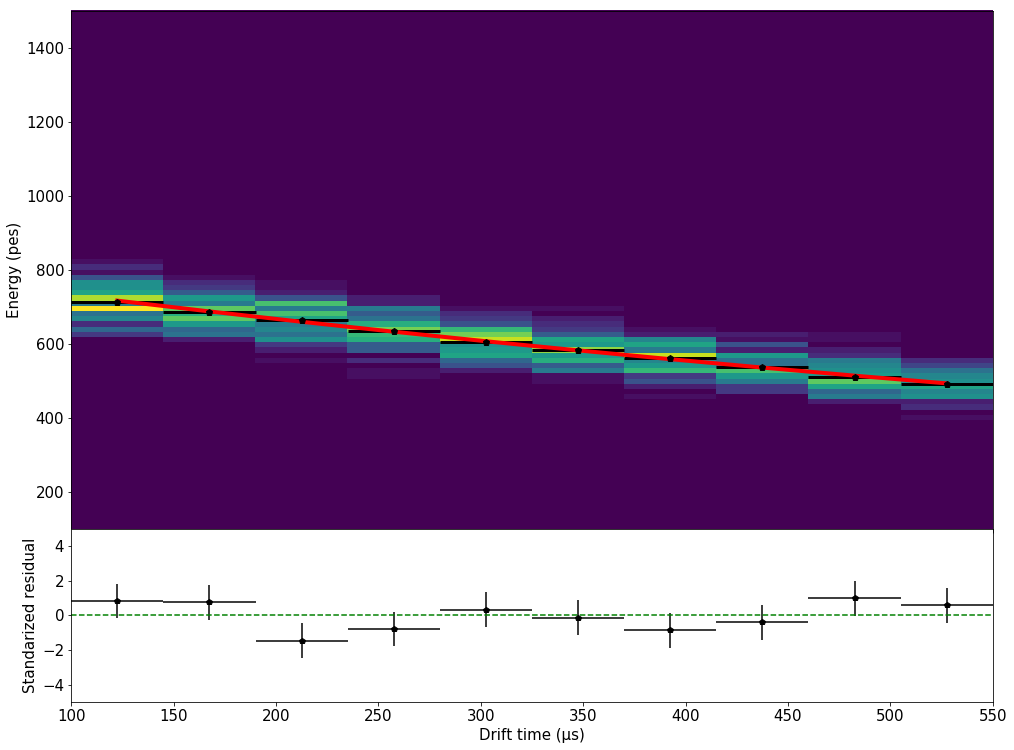

In [13]:
xlim =  15,  25
ylim = -25, -15
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
z, q = Z[sel], Q[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.hist2d(z, q, (Zbins, Qbins))

x, y, yu = fitf.profileX(z, q, Znbins, Zrange)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

seed = expo_seed(x, y)
f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Energy (pes)", "Lifetime fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Drift time (µs)", "Standarized residual")

save("LifetimeQ_fit_example")

### Map display

Average lifetime             (mean +- rms) = (1513 +- 64) µs
Average lifetime uncertainty (mean +- rms) = (1.21 +- 0.14) (%)


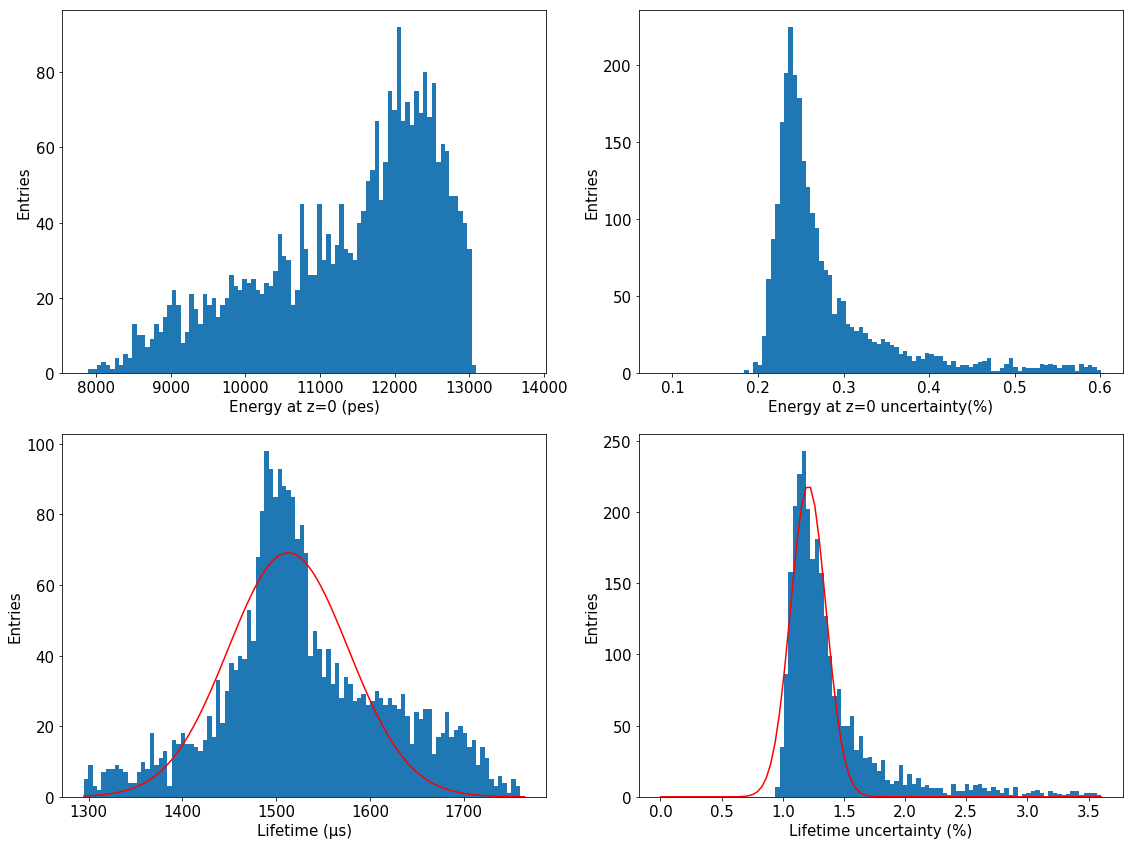

In [14]:
plt.subplot(2, 2, 1)
bins    = np.linspace(E_min, E_max, 101)
y, x, _ = plt.hist(Escale.value.flatten(), bins)
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Eu_min, Eu_max, 101)
y, x, _ = plt.hist(Escale.uncertainty.flatten(), bins)
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(ELT_min, ELT_max, 101)
y, x, _ = plt.hist       (-ELT.value.flatten(), bins)
f       = quick_gauss_fit(-ELT.value.flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(ELTu_min, ELTu_max, 101)
y, x, _ = plt.hist       (ELT.uncertainty.flatten(), bins)
fu      = quick_gauss_fit(ELT.uncertainty.flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

plt.tight_layout()

save("Lifetime_and_energy_scale_distributions")

print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

Average lifetime             (mean +- rms) = (1100 +- 57) µs
Average lifetime uncertainty (mean +- rms) = (2.52 +- 0.30) (%)


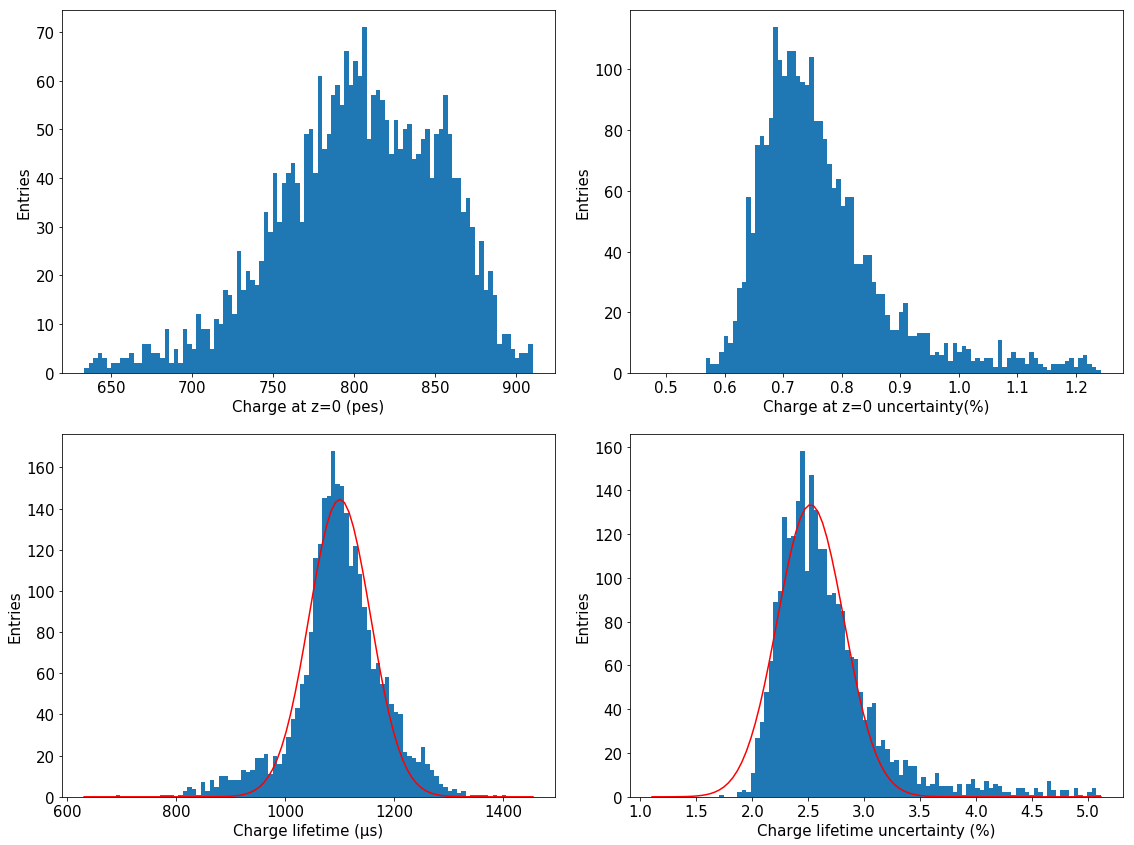

In [15]:
plt.subplot(2, 2, 1)
bins    = np.linspace(Q_min, Q_max, 101)
y, x, _ = plt.hist(Qscale.value.flatten(), bins)
labels("Charge at z=0 (pes)", "Entries", "Charge scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Qu_min, Qu_max, 101)
y, x, _ = plt.hist(Qscale.uncertainty.flatten(), bins)
labels("Charge at z=0 uncertainty(%)", "Entries", "Charge scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(QLT_min, QLT_max, 101)
y, x, _ = plt.hist       (-QLT.value.flatten(), bins)
f       = quick_gauss_fit(-QLT.value.flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Charge lifetime (µs)", "Entries", "Charge lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(QLTu_min, QLTu_max, 101)
y, x, _ = plt.hist       (QLT.uncertainty.flatten(), bins)
fu      = quick_gauss_fit(QLT.uncertainty.flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Charge lifetime uncertainty (%)", "Entries", "Charge lifetime uncertainty distribution")

plt.tight_layout()

save("Lifetime_and_charge_scale_distributions")

print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

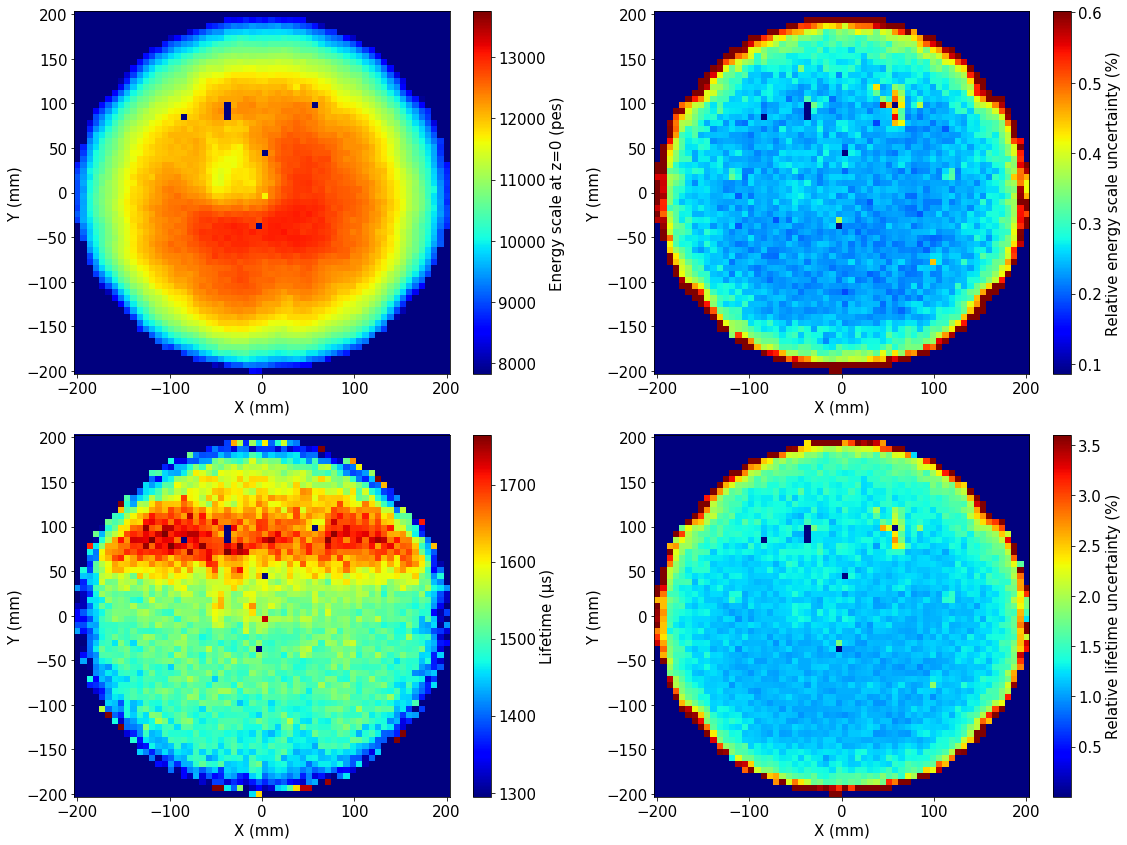

In [16]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.value,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.uncertainty,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, -ELT.value,
                        vmin = ELT_min,
                        vmax = ELT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, ELT.uncertainty,
                        vmin = ELTu_min,
                        vmax = ELTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_energy_scale_maps")

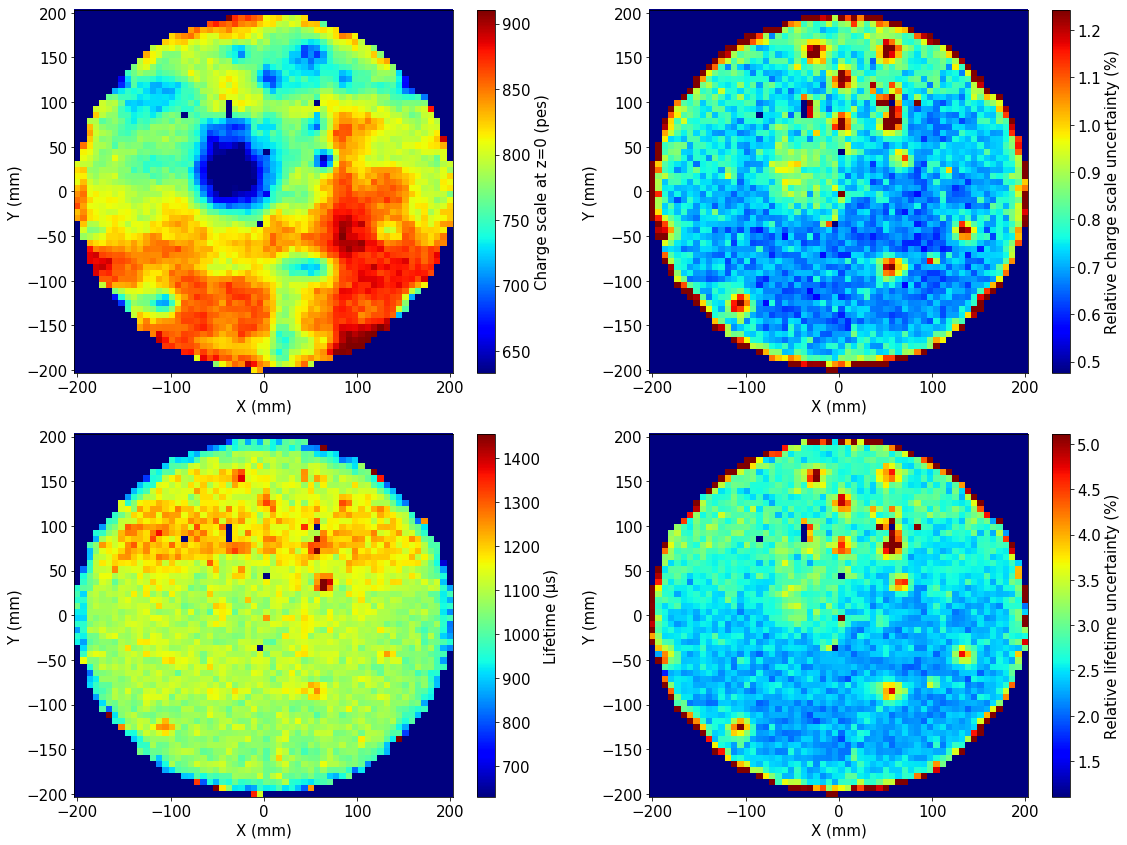

In [17]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.value,
                        vmin = Q_min,
                        vmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Charge scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Charge scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.uncertainty,
                        vmin = Qu_min,
                        vmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative charge scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative charge scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, -QLT.value,
                        vmin = QLT_min,
                        vmax = QLT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, QLT.uncertainty,
                        vmin = QLTu_min,
                        vmax = QLTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_charge_scale_maps")

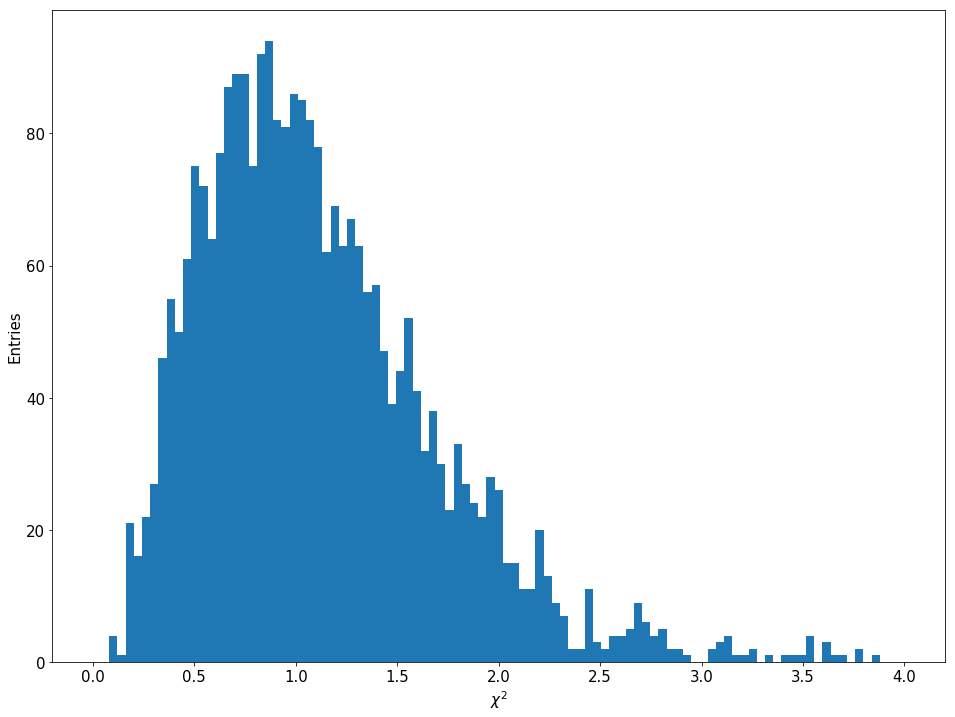

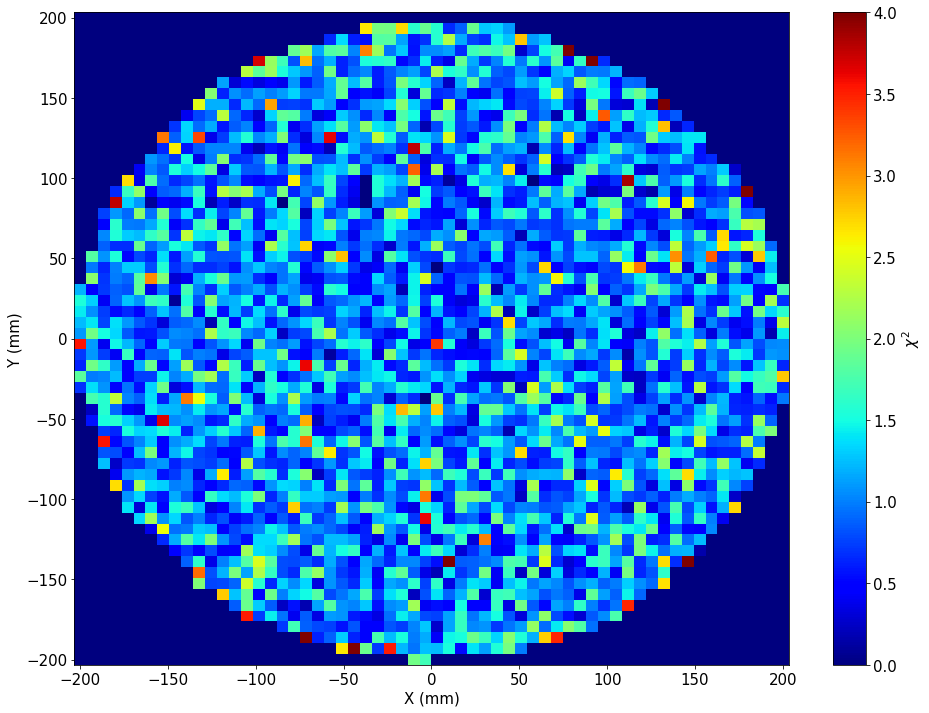

In [18]:
plt.hist(Echi2[Echi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Echi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

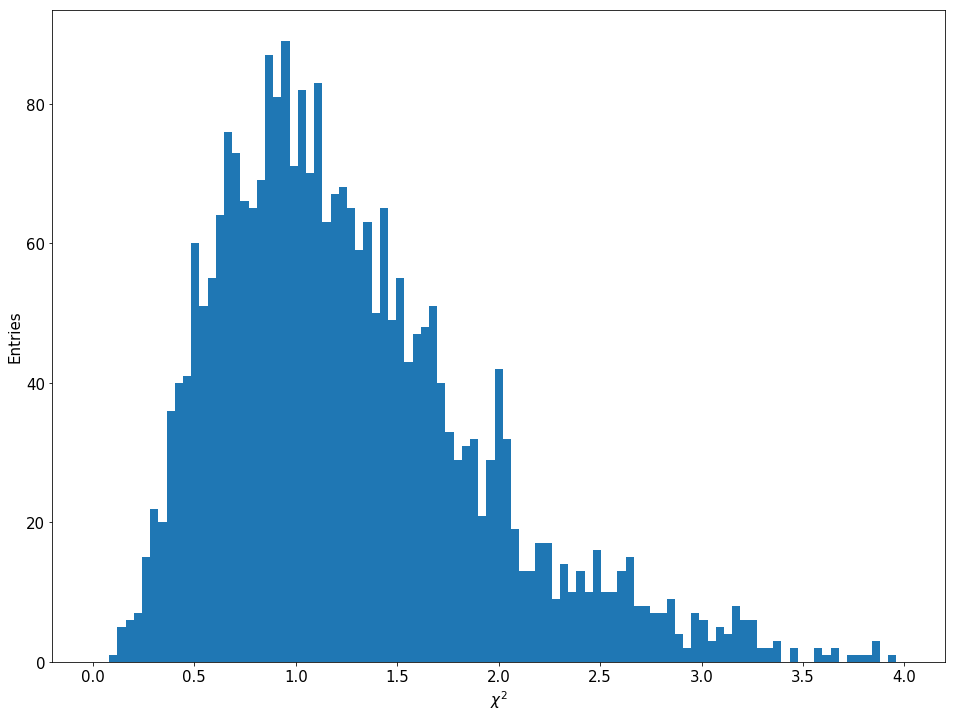

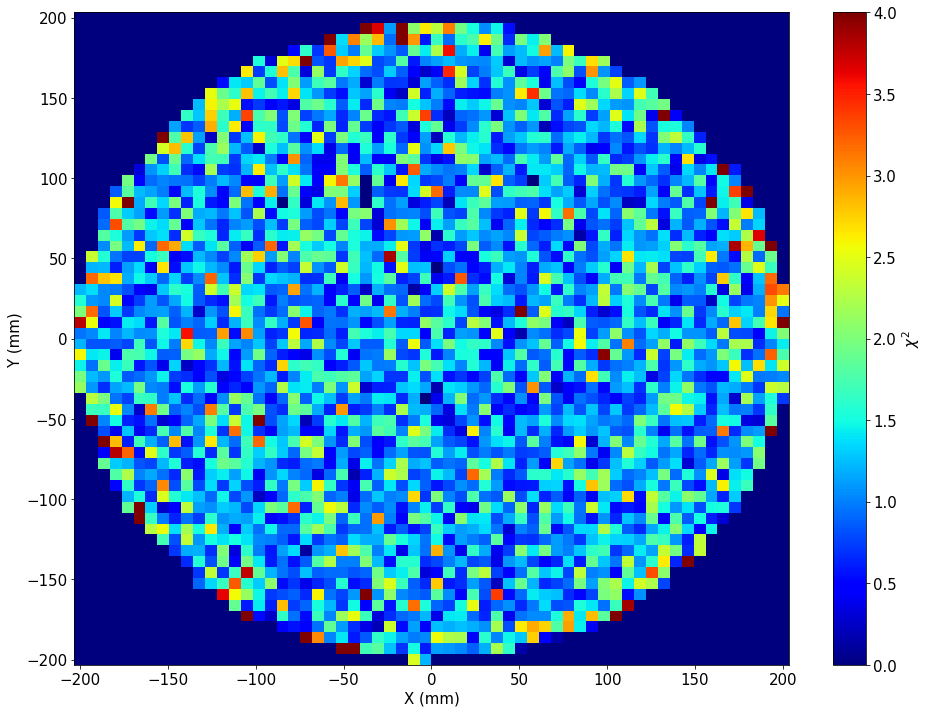

In [19]:
plt.hist(Qchi2[Qchi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Qchi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [20]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(Eok, Escale_abs.value      ,     E_mean)
Escaleu_safe = np.where(Eok, Escale_abs.uncertainty,    Eu_mean *   E_mean / 100)

ELT_safe     = np.where(Eok,   -ELT_abs.value      , - ELT_mean)
ELTu_safe    = np.where(Eok,    ELT_abs.uncertainty, -ELTu_mean * ELT_mean / 100)

Qscale_safe  = np.where(Qok, Qscale_abs.value      ,     Q_mean)
Qscaleu_safe = np.where(Qok, Qscale_abs.uncertainty,    Qu_mean *   Q_mean / 100)

QLT_safe     = np.where(Qok,   -QLT_abs.value      , - QLT_mean)
QLTu_safe    = np.where(Qok,    QLT_abs.uncertainty, -QLTu_mean * QLT_mean / 100)

with tb.open_file(correction_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_safe, ELTu_safe, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch

    write_qscale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Qscale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Qscale_safe, Qscaleu_safe, nevt)
    correction_file.root.XYcorrections.Qscale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Qscale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "QLifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, QLT_safe, QLTu_safe, nevt)
    correction_file.root.XYcorrections.QLifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.QLifetime.attrs.xy_pitch = XYpitch